In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


In [2]:
data_df = pd.read_csv("news_ling_features.csv")

In [4]:
data_df.head()

,text,Polarity,t_syll3,a_char_pw,simp_adj_var,simp_adv_var,simp_intj_var,simp_noun_var,simp_num_var,simp_pron_var,...,a_punct_pw,a_sconj_pw,a_sym_pw,a_verb_pw,a_space_pw,a_intj_ps,a_num_ps,a_pron_ps,a_propn_ps,smog
0,"You Can Smell Hillary’s FearDaniel Greenfield,...",0,56,4.22,0.80,0.66,0.0,0.66,0.60,0.17,...,0.08,0.02,0.0,0.11,0.02,0.0,0.06,1.39,1.77,4.58
1,Watch The Exact Moment Paul Ryan Committed Pol...,0,21,4.67,0.97,0.96,0.0,0.90,0.67,0.33,...,0.13,0.02,0.0,0.14,0.02,0.0,0.35,1.62,2.35,5.13
2,Kerry to go to Paris in gesture of sympathyU.S...,1,16,4.67,0.90,0.92,0.0,0.76,0.50,0.41,...,0.09,0.03,0.0,0.12,0.02,0.0,0.12,1.71,4.59,5.54
3,Bernie supporters on Twitter erupt in anger ag...,0,27,5.09,0.84,1.00,0.0,0.77,0.48,0.67,...,0.18,0.01,0.0,0.10,0.03,0.0,1.21,0.95,4.58,6.81
4,The Battle of New York: Why This Primary Matte...,1,11,4.31,0.85,0.92,0.0,0.65,1.00,0.43,...,0.15,0.02,0.0,0.12,0.03,0.0,0.38,1.00,2.76,4.13


In [5]:
# getting the feature info dictionaries for reference

import lftk

features = lftk.search_features(return_format="list_dict")

no permutation as feature selection since with colinear features, the info will be obtainable with a different feature

In [76]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from yellowbrick.model_selection import rfecv
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

workflow: 
- initialize standard basic default models
- determine PCA hyperparams - 33 components
- make 2 pipelines: 
        pipe 1: scale, pca, train test
        pipe 2: scale feature selection, trian test
- compare the perf of the models
- select 1
- hyper param tuning

In [47]:
X = data_df.drop(["text", "Polarity"], axis=1)
X_stand = scaler.fit_transform(X)

y = data_df["Polarity"]

## PCA

In [48]:
pca = PCA()
scaler = StandardScaler()

pca_fit = pca.fit(X_stand)
cum_explained_ratio = np.cumsum(pca_fit.explained_variance_ratio_)

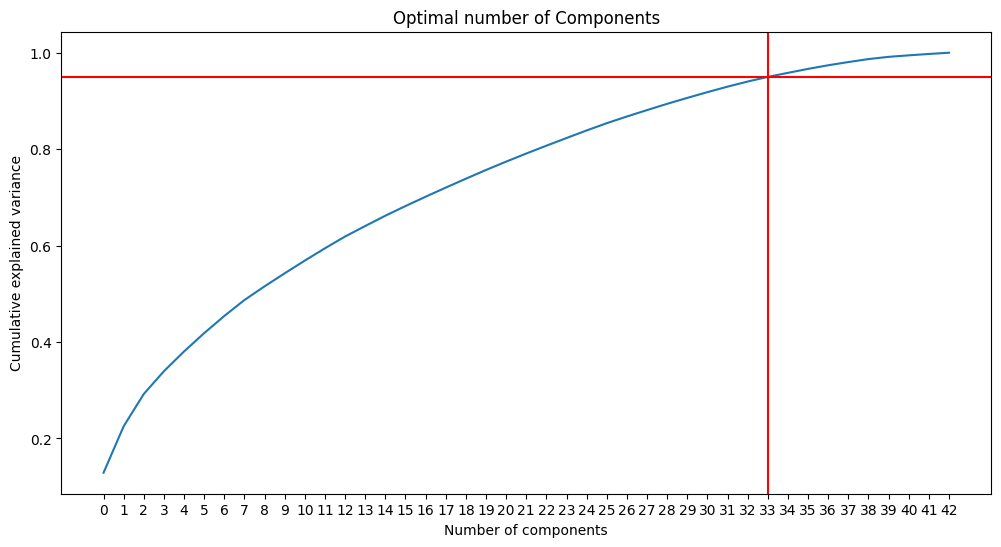

In [49]:
plt.plot(cum_explained_ratio)

plt.axhline(y = 0.95, color = 'r', linestyle = '-')
plt.axvline(x = 33, color = 'r', linestyle = '-')
plt.xticks(ticks=np.arange(0, len(cum_explained_ratio), step=1))

plt.title("Optimal number of Components")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [50]:
len(X.columns)

43

33 vs 43

## Recursive Feature Elimination

In [53]:
rfecv = rfecv(RandomForestClassifier(), scoring="f1_weighted")
rfecv.fit(X, y)

RFECV(estimator=RandomForestClassifier(), scoring='f1')

In [ ]:
rfecv.show()

In [62]:
rfecv.support_

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True])

In [68]:
features = list(rfecv.get_feature_names_out())
selection_mask = list(rfecv.support_)

In [69]:
len(features)

39

In [70]:
selection_mask.count(False)

4

In [66]:
from itertools import compress

selected_features = list(compress(features, selection_mask))

In [67]:
selected_features

['t_syll3',
 'a_char_pw',
 'simp_adj_var',
 'simp_adv_var',
 'simp_num_var',
 'simp_pron_var',
 'simp_propn_var',
 'simp_sconj_var',
 'simp_sym_var',
 'simp_verb_var',
 'simp_space_var',
 'root_aux_var',
 'root_part_var',
 'root_propn_var',
 'root_space_var',
 'corr_adp_var',
 'corr_cconj_var',
 'corr_det_var',
 'corr_pron_var',
 'corr_punct_var',
 'corr_sconj_var',
 'uber_ttr_no_lem',
 'a_adj_pw',
 'a_adp_pw',
 'a_adv_pw',
 'a_aux_pw',
 'a_cconj_pw',
 'a_det_pw',
 'a_noun_pw',
 'a_punct_pw',
 'a_verb_pw',
 'a_space_pw',
 'a_pron_ps',
 'a_propn_ps',
 'smog']

## Models

In [115]:
def score_models(X, y, model, selected_features=selected_features, pca=PCA(n_components=33), cv=StratifiedKFold(n_splits=5)):
    
    X_features = X[selected_features]
    X_pca = pca.fit_transform(X)
    
    scores_rfe = cross_validate(model, X_features, y, scoring = ["f1_weighted", "accuracy", "precision", "recall"], cv=cv)
    scores_pca = cross_validate(model, X_pca, y, scoring = ["f1_weighted", "accuracy", "precision", "recall"], cv=cv)
    
    processed_scores_rfe = {f"mean_{key}": np.mean(value) for key, value in scores_rfe.items()}
    processed_scores_pca = {f"mean_{key}": np.mean(value) for key, value in scores_pca.items()}
    
    processed_scores_rfe["model_name"] = str(model)[:-2]
    processed_scores_pca["model_name"] = str(model)[:-2]
    
    processed_scores_rfe["method"] = "rfe"
    processed_scores_pca["method"] = "pca"
    
    return processed_scores_rfe, processed_scores_pca

In [116]:
models = [RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier()]
scores = []

for model in models:
    processed_scores_rfe, processed_scores_pca = score_models(X, y, model)

    scores.append(processed_scores_rfe)
    scores.append(processed_scores_pca)

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

In [117]:
scores

[{'mean_fit_time': 1.1905955791473388,
  'mean_score_time': 0.0233762264251709,
  'mean_test_f1_weighted': 0.7944248158404319,
  'mean_test_accuracy': 0.794475138121547,
  'mean_test_precision': 0.8005329656862884,
  'mean_test_recall': 0.785554037606498,
  'model_name': 'RandomForestClassifier',
  'method': 'rfe'},
 {'mean_fit_time': 2.434955024719238,
  'mean_score_time': 0.02211480140686035,
  'mean_test_f1_weighted': 0.7717961449248383,
  'mean_test_accuracy': 0.771902131018153,
  'mean_test_precision': 0.7838549469811451,
  'mean_test_recall': 0.7515030179587174,
  'model_name': 'RandomForestClassifier',
  'method': 'pca'},
 {'mean_fit_time': 1.9560118675231934,
  'mean_score_time': 0.008108043670654297,
  'mean_test_f1_weighted': 0.7839501577684255,
  'mean_test_accuracy': 0.7840568271507499,
  'mean_test_precision': 0.7749635602988411,
  'mean_test_recall': 0.8016349139322884,
  'model_name': 'GradientBoostingClassifier',
  'method': 'rfe'},
 {'mean_fit_time': 5.755415678024292,

## Results

In [118]:
results_df = pd.DataFrame(scores)

In [119]:
results_df

,mean_fit_time,mean_score_time,mean_test_f1_weighted,mean_test_accuracy,mean_test_precision,mean_test_recall,model_name,method
0,1.190596,0.023376,0.794425,0.794475,0.800533,0.785554,RandomForestClassifier,rfe
1,2.434955,0.022115,0.771796,0.771902,0.783855,0.751503,RandomForestClassifier,pca
2,1.956012,0.008108,0.783950,0.784057,0.774964,0.801635,GradientBoostingClassifier,rfe
3,5.755416,0.007836,0.760380,0.760537,0.749782,0.783031,GradientBoostingClassifier,pca
4,0.463589,0.016734,0.740515,0.740805,0.727398,0.771360,AdaBoostClassifier,rfe
5,1.223052,0.014882,0.736387,0.736701,0.724712,0.765051,AdaBoostClassifier,pca
